In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from jax import numpy as jnp
import jax
from typing import List, Union

pd.options.plotting.backend = "plotly"

from summer.utils import ref_times_to_dti

from summer2 import CompartmentalModel, Stratification
from summer2.parameters import Parameter, Function, Data

from autumn.projects.sm_sir.australia.northern_territory.project import get_ts_date_indexes
from autumn.core.project import load_timeseries
from autumn.core import inputs

In [2]:
# This should be adapted before actually using this properly,
# but just gets us some data in that we could use for calibration
ts_set = load_timeseries("../../../autumn/projects/sm_sir/malaysia/malaysia/timeseries.json")

COVID_BASE_DATETIME = datetime(2019, 12, 31)

In [3]:
def find_latent_transition_rate(
    base_comps: List[str], 
    latent_parameter: str,
) -> Parameter:
    n_exposed_comps = len([c for c in base_comps if "_exposed" in c])
    latent_period = Parameter(latent_parameter) / n_exposed_comps
    return 1. / latent_period

In [4]:
age_groups = range(0, 80, 5)

age_pops = pd.Series(
    inputs.get_population_by_agegroup(age_groups, "MYS", None, 2020),
    index=age_groups
)

In [5]:
def build_unstratified_model(settings: dict) -> CompartmentalModel:
    """
    Create a compartmental model, with the minimal compartmental structure needed to run and produce some sort of 
    meaningful outputs.
    
    Args:
        parameters: Parameters for use in model construction    
    Returns:
        A compartmental model currently without stratification applied
    """

    base_comps = [
        "susceptible",
        "early_exposed",
        "late_exposed",
        "infectious",
        "recovered",
    ]
    
    model = CompartmentalModel(
        [
            settings["start_time"], 
            settings["end_time"],
        ],
        base_comps,
        ["infectious"],
        timestep=1.,
    )
    
    model.set_initial_population(
        {
            "susceptible": Parameter("total_population") - Parameter("seed_size"), 
            "infectious": Parameter("seed_size"),
        }
    )
    
    model.add_infection_frequency_flow(
        "infection", 
        Parameter("contact_rate"),
        "susceptible", 
        "early_exposed",
    )

    latent_rate = find_latent_transition_rate(base_comps, "latent_period")
        
    model.add_transition_flow(
        "early_progression",
        latent_rate,
        "early_exposed",
        "late_exposed",
    )
    
    model.add_transition_flow(
        "late_progression",
        latent_rate,
        "late_exposed",
        "infectious",
    )
    
    model.add_transition_flow(
        "recovery",
        Parameter("recovery_rate"),
        "infectious",
        "recovered",
    )
    
    model.request_output_for_flow(
        "progressions",
        "late_progression",
    )
    
    def prop_detected(progressions):
        return progressions * settings["cdr"]
    
    model.request_function_output(
        "notifications",
        func=prop_detected,
        sources=["progressions"],
    )
    
    return model

In [6]:
def get_age_strat(
    compartments_to_stratify: List[str],
    strata: List[str],
) -> Stratification:
    # Create the stratification, just naming the age groups by their starting value
    strat = Stratification(name="age", strata=strata, compartments=compartments_to_stratify)
    
    age_split_props = age_pops / age_pops.sum()
    strat.set_population_split(age_split_props.to_dict())
    
    return strat

In [9]:
age_pops.index

Index(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55',
       '60', '65', '70', '75'],
      dtype='object')

In [16]:
parameters = {
    "contact_rate": 1.2,
    "recovery_rate": 1.0,
    "total_population": age_pops.sum(),
    "seed_size": 10.,
    "latent_period": 1.,
}
settings = {
    "start_time": 670.,
    "end_time": 900.,
    "cdr": 0.15,
}

malaysia_model = build_unstratified_model(settings)

age_pops.index = age_pops.index.astype(str)

age_strat = get_age_strat(malaysia_model.compartments, age_pops.index)

malaysia_model.stratify_with(age_strat)

malaysia_model.run(parameters)

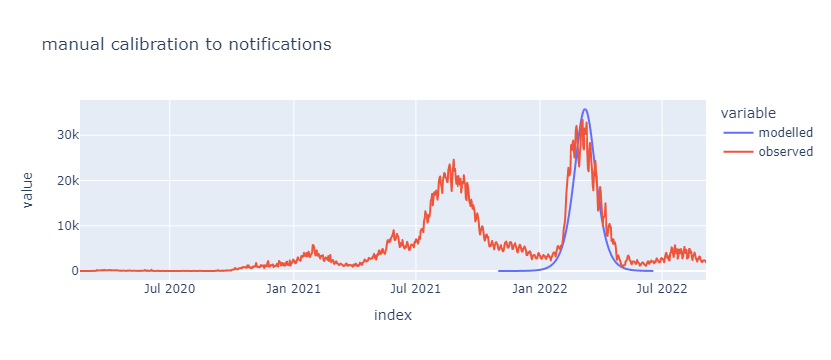

In [14]:
# Process the modelled notifications
notifs = malaysia_model.get_derived_outputs_df()["notifications"]
notifs_dates = notifs
notifs_dates.index = ref_times_to_dti(COVID_BASE_DATETIME, notifs.index)

# Process the observed notifications
ts_set_dates = get_ts_date_indexes(ts_set, COVID_BASE_DATETIME)

# Collate
comparison_outputs = pd.DataFrame(
    {
        "modelled": notifs_dates,
        "observed": ts_set_dates["notifications"],
    }
)

# Plot
comparison_outputs.plot(title="manual calibration to notifications")

In [ ]:
malaysia_model.get_input_parameters()

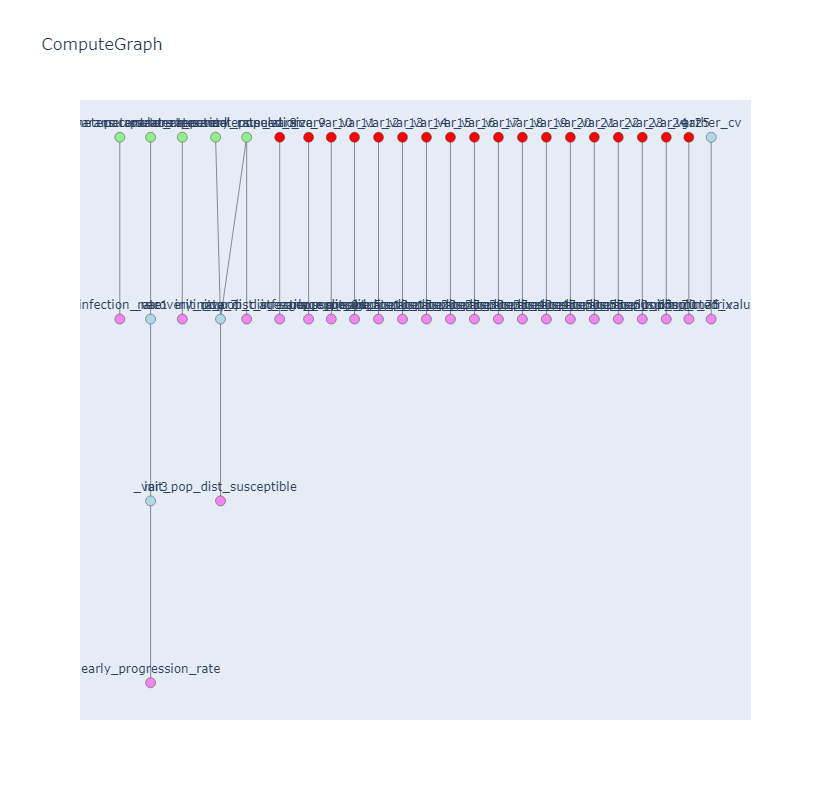

In [18]:
malaysia_model.graph.draw()

In [ ]:
# malaysia_model.graph.filter("early_progression_rate").draw()